<center><h1> Assignment 2 </h1></center>

In this assignment, you will implement a [Transformer](https://arxiv.org/abs/1706.03762) from the bottom up by filling in the bodies of the `__init__` and `forward` functions of these partially written classes (but feel free to write other helper/utility functions as needed):

- `MultiheadAttention`,
- `TransformerEncoderLayer`, and
- `TransformerDecoderLayer`.

You can test your classes against the corresponding PyTorch classes,
- `nn.MultiheadAttention`,
- `nn.TransformerEncoderLayer`, and
- `nn.TransformerDecoderLayer`,

using the tests included in this notebook:
- `test_multihead_attention`,
- `test_transformer_encoder_layer`, and
- `test_transformer_decoder_layer`.



## Review of Convolutions

1. [1/4 mark] If the input volume has dimensions 10 x 10 x 32 (Height x Width x Channels), how many weights (including biases) will be there in a filter that considers an area of 5 x 5?

  * number of weights per filter = (height of the filter x width of the filter x Channels) + 1 (for bias)
  * Hence, number of weights per filter = (5 x 5 x 32) + 1 = 801

2. [1/4 mark] If input volume has dimensions 10 x 10 x 32 and after convolution we get an output volume of 8 x 8 x 64, how many filters were used?

  * number of filters used = number of channels in the output volume
  * number of filters used = 64

## Review of Transformers

Please note that your answers must be clear. If we cannot understand exactly what is written, points will be deducted.

1. [1/2 mark] What is inverted dropout? Where is dropout used in Transformers?
  * In traditional dropout, some of the weights are randomly set to 0 based on a 'keep probability' (probability that a weight value is kept). This ensures that with each iteration, you train a different subset of neurons, making it less sensitive to the activation of one other specific neuron.
  * Inverted dropout is a kind of a variation of the traditional dropout, where it scales the activations by the inverse of the keep probability (1-p).
  * It stops the neuron activations from getting too big and will not need changes in the test phase. But in traditional dropout, scaling is required in the test phase.
  * In Transformers, dropout is applied to the output of each sub-layer, before it is added to the 'Add & Norm' sub-layer. It is also applied to the sums of the embeddings and the positional encodings in both the encoder and decoder layers.
  * Reference:
    * https://teetracker.medium.com/dropout-inverted-dropout-ec5d16d7a473
    * https://arxiv.org/pdf/1706.03762.pdf

2. [1 mark] In the context of the Multihead Attention class,
  * a) Describe and distinguish between Padding Masks and Attention Masks.
    * Padding helps with ensuring fixed length inputs. When input sequences are fed into the model, they are padded with zeros to make sure they have the same length.
    * Padding masks are matrices with 1 (padded token) or 0 (valid token). And during attention the padded tokens are masked out, to make sure that do not contribute to the attention scores and create noise.
    * Attention masks could be binary (valid or invalid position) or weighted (importance of the position). It ensures which positions in the input sequence the model has to attend to. It ensures that the predictions for position i can depend only on the known outputs at positions less than i.
    * Reference:
      * https://arxiv.org/pdf/1706.03762.pdf
  * b) Observe that the Padding mask is of shape (batch_size, in_sequence_len); therefore, in the encoder-decoder attention stage, the padding mask indicates the padding tokens in the encoder output. Why is not necessary to have a padding mask for the decoder-input?
    * In the encoder stage, the passing mask is important to not attend to the padded positions of the input sequence. Else, the model might learn irrelavant patterns.
    * But, the decoder takes the target sequence input one token at a time and not the entire sequence at once. At each iteration, the decoder generates a token and uses it as input for the next iteration. It naturally avoids attending to padding tokens because they do not occur in the input.
    * Hence, it is not necessary to have a padding mask for the decoder input.

3. [1/2 mark] What does the statement "The decoder is autoregressive" mean to you? Describe the implications of this in terms of training (hint: think about the attention-masks and look up "teacher forcing") and inference stage.
  * In the training stage, the decoder layer learns based on the ground truth and the encoder outputs. The decoder receives the actual target token from the previous timestamp as input for the current timestamp.
    * And, the decoder computes context vectors using the attention mechanism. It attends to relevant encoder positions based on the current hidden state and the previously generated tokens. And it generates tokens sequentially.
  * In the inference stage, it doesn't know the ground truth, so it predicts the next token based on the previous context and previously generated tokens. Casual mask is used to avoid looking ahead at the future positions. And it generates sequentially one after the other.
  * This ensures that the model learns to predict accurately due to its autoregressive nature.
  * Reference:
    * https://saturncloud.io/glossary/teacher-forcing/
    * https://leimao.github.io/blog/Autoregressive-Model-Autoregressive-Decoding/

4. [1/2 mark] What is Beam Search?
  * Beam Search is an improvement over greedy search. Instead of choosing a single best word, it uses the best 'n'(hyperparameter) words. It picks the 'n' best sequences so far and considers the probabilities of the combination of all the previous words, along with the word in the current position till it reaches the end character.
  * It ensures that the best possible sentence is generated, instead of the best possible word.
  * Example:
  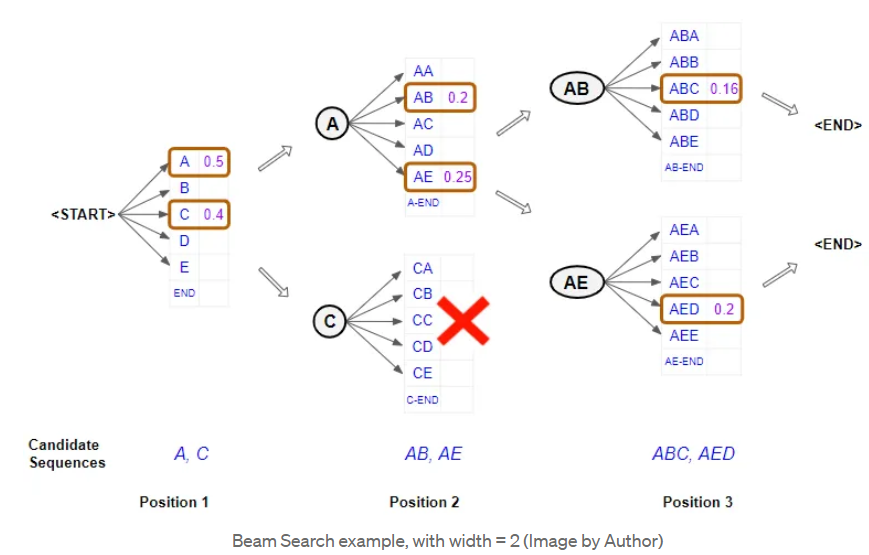
  * If beam width N = 2, then here,
    * in the first step: both A,B is chosen
    * in the second step: A and its next letter's probabilities and B and its next letter's probabilities are checked to choose the best 2
    * and so on till <end>
  * Reference
    * https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24
    * https://d2l.ai/chapter_recurrent-modern/beam-search.html#id1
    

5. [1 mark] In autoregressive decoding, the input to the next time step is sampled according to the probabilities predicted at the current time step. Assuming that the vocabulary is ["cat", "dog", "mouse", "chases", "eats"] and the predicted probabilities are [0.6, 0.1, 0.1, 0.1, 0.1], complete the function below that takes in the vocabulary and probabilities and test it with the values in this question.

In [ ]:
# Code here
import random

def sample(vocab, probs):

  # sample word based on probs
  sampled_word = random.choices(vocab, weights=probs, k=1)[0]
  return sampled_word

# testing
vocab = ["cat", "dog", "mouse", "chases", "eats"]
probs = [0.6, 0.1, 0.1, 0.1, 0.1] # sum(probs) should be 1

sampled_word = sample(vocab, probs)
print("Sampled word:", sampled_word)

Sampled word: cat


# Choose 1 of the following (or both for potential bonus marks)

* 6 (a). [2 marks] What is Layernorm? How is this different from batchnorm? Briefly discuss their advantages and disadvantages. You are required to find and refer to papers in detail wherever appropriate.
  * LayerNorm normalizes the activations of each layer *independently* using the mean and variance across the features for each data point.
  * It normalizes all features within each sample, which makes it good for tasks where the batch dimension is small or even absent.
  * It does not depend on batch size during training, so it works well with varying batch sizes and RNNs.
  * But, it may not work as well as BatchNorm when the features are highly correlated. It will not be able to generalize very well.
  * Computationally more work and costlier than batch norm.
  * BatchNorm normalizes the activations of each layer by calculating the mean and variance *across the entire batch*.
  * This makes batch norm much more faster and stable as it reduces the impact of weight initialization and internal covariate shift.
  * But, batch normalization relies on accurate estimates of mean and variance computed from the mini-batches. So with small batch sizes, these estimates become less reliable due to limited data points.
  * Reference
    * https://arxiv.org/pdf/1502.03167.pdf
    * https://arxiv.org/pdf/1607.06450.pdf
    * https://medium.com/@florian_algo/batchnorm-and-layernorm-2637f46a998b#:~:text=BatchNorm%20normalizes%20each%20feature%20within,all%20features%20within%20each%20sample.

* 6 (b). [2 marks] What are residual connections? Find out about the importance of residual connections and layer normalization in Transformers and state what you found. You are required to find and refer to papers in detail wherever appropriate.
  * Deeper models face the issue of accuracy saturation. Adding more layers does not solve the problem.
  * Residual connections solve this issue by allowing the network to learn meaningful inputs. Instead of directly learning the output, the difference between the output and the input = residue is used.
  * output = input + residual
  * During backprop, the gradients can blowup and vanish through non-linear activations. But with residual connections in the computational graph, the gradients are not lost, which is essential for training.
  * LayerNorm normalizes activations within each layer *independently*.
  * So, it ensures stable training and prevents vanishing gradients. And it operates on individual tokens, preserving local information.
  * Residual connections and layer normalization is implemented in the encoder and decoder layer in Transformers.
  * In encoder, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself.
  * And in decoder, similar to the encoder, residual connections are used around each of the sub-layers, followed by layer normalization.
  * Reference
    * https://arxiv.org/pdf/1607.06450.pdf
    * https://arxiv.org/pdf/1706.03762.pdf
    * https://medium.com/@florian_algo/batchnorm-and-layernorm-2637f46a998b#:~:text=BatchNorm%20normalizes%20each%20feature%20within,all%20features%20within%20each%20sample.

## Rough marking scheme

<table>
  <tr>
    <td><b> Item </b></td>
    <td><b> Relative score </b></td>
  </tr>
  <tr>
    <td> MultiheadAttention implementation </td>
    <td> 7 </td>
  </tr>
  <tr>
    <td> TransformerEncoderLayer implementation </td>
    <td> 1 </td>
  </tr>
  <tr>
    <td> TransformerDecoderLayer implementation </td>
    <td> 1 </td>
  </tr>
  <tr>
    <td> Review Questions </td>
    <td> 6 </td>
  </tr>
  <tr>
    <td> Bonus Questions </td>
    <td> 2 </td>
  </tr>
  <tr>
    <td> Total </td>
    <td> 15 [+ upto 2 bonus] </td>
  </tr>
  </table>

In [ ]:
import numpy as np
import torch
import torch.nn as nn

In [ ]:
class MultiheadAttention(nn.Module):
    """Clone of nn.MultiheadAttention."""

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.in_proj_weight = nn.Parameter(torch.FloatTensor(3 * embed_dim, embed_dim))
        self.in_proj_bias = nn.Parameter(torch.zeros(3 * embed_dim))
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.num_heads = num_heads

    def forward(self, x_query, x_key, x_value, padding_mask=None, attn_mask=None):
        """
        x_query          : (batch_size, out_sequence_len, embed_dim)
        x_key            : (batch_size, in_sequence_len,  embed_dim)
        x_value          : (batch_size, in_sequence_len,  embed_dim)
        padding_mask     : (batch_size, in_sequence_len)
        attn_mask        : (out_sequence_len, in_sequence_len)

        returns attn_out : (batch_size, out_sequence_len, embed_dim)
        """

        # Make sure the shapes of the input tensors are valid
        for x in [x_query, x_key, x_value]:
            assert(len(x.shape) == 3)
            assert(x.shape[2] == self.embed_dim)
        assert(x_query.shape[0] == x_key.shape[0] == x_value.shape[0])
        assert(x_key.shape[1] == x_value.shape[1])

        # Extract the input shapes
        batch_size, out_sequence_len = x_query.shape[:2]
        in_sequence_len = x_key.shape[1]

        # Get the weights for building the query, key, and value matrices
        query_weights = self.in_proj_weight[:self.embed_dim]
        query_biases = self.in_proj_bias[:self.embed_dim]

        key_weights = self.in_proj_weight[self.embed_dim:2 * self.embed_dim]
        key_biases = self.in_proj_bias[self.embed_dim:2 * self.embed_dim]

        value_weights = self.in_proj_weight[2 * self.embed_dim:]
        value_biases = self.in_proj_bias[2 * self.embed_dim:]

        # Compute the Q, K, V matrices. These each have
        # shape (batch_size, *_sequence_len, embed_dim).
        queries = x_query @ query_weights.T + query_biases
        keys = x_key @ key_weights.T + key_biases
        values = x_value @ value_weights.T + value_biases

        # Your job here is to finish writing this class so that the correct
        # attn_out is returned. Following this comment, your code should do
        # something like:

        # 1. Separate the queries, keys, and values into heads [This one has been done for you!]
        # 2. Compute the attention scores for each head
        # 3. If padding_mask is not None, apply padding_mask to the scores
        # 4. If attn_mask is not None, apply attn_mask to the scores
        # 5. Compute the attention weights from the attention scores using a softmax
        # 6. Apply the attention weights to the values
        # 7. Concatenate the heads
        # 8. Apply out_proj to the concatenated heads

        # 1. Separate out the embedding into corresponding heads
        queries = queries.reshape(batch_size, out_sequence_len, self.num_heads, self.embed_dim//self.num_heads)
        keys = keys.reshape(batch_size, in_sequence_len, self.num_heads,  self.embed_dim//self.num_heads)
        values = values.reshape(batch_size, in_sequence_len, self.num_heads, self.embed_dim//self.num_heads)

        # (Write code here)

        # 2. Compute the attention scores for each head
        attn_scores = torch.einsum('bqhd,bkhd->bhqk',[queries,keys])/((self.embed_dim//self.num_heads) ** 0.5)

        # 3. If padding_mask is not None, apply padding_mask to the scores
        if padding_mask is not None:

            padding_mask = padding_mask.unsqueeze(1).unsqueeze(1)  # shape: [3, 1, 1, 200]
            # Broadcast padding_mask across attn_score
            padding_mask = padding_mask.expand(-1, attn_scores.size(1), attn_scores.size(2), -1)
            # Apply padding_mask to attn_score
            attn_scores = attn_scores.masked_fill(padding_mask, float('-inf'))


        # 4. If attn_mask is not None, apply attn_mask to the scores
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)
            attn_mask = attn_mask.expand(attn_scores.size(0),attn_scores.size(1), -1, -1)
            attn_scores = attn_scores.masked_fill(attn_mask, float('-inf'))

        # 5. Compute the attention weights from the attention scores using a softmax
        attn_weights = nn.functional.softmax(attn_scores, dim= -1)

        # 6. Apply the attention weights to the values
        attention_values = torch.einsum('bhqk,bkhd->bqhd', attn_weights, values)

        # 7. Concatenate the heads
        attn_output = attention_values.reshape(batch_size,out_sequence_len,self.embed_dim)

        # 8. Apply out_proj to the concatenated heads
        attn_out = self.out_proj(attn_output)

        return attn_out

class TransformerEncoderLayer(nn.Module):
    """Clone of nn.TransformerEncoderLayer."""

    def __init__(self, embed_dim, num_heads, dim_feedforward=2048):
        super().__init__()
        self.self_attn = MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)

    def forward(self, x, padding_mask=None, attn_mask=None):
        """
        x                   : (batch_size,   sequence_len, embed_dim)
        padding_mask        : (batch_size,   sequence_len)
        attn_mask           : (sequence_len, sequence_len)

        returns encoder_out : (batch_size,   sequence_len, embed_dim)
        """

        # Your job here is to finish writing this class so that the correct
        # encoder_out is returned. Following this comment, your code should
        # do something like:

        # 1. Apply the self-attention
        # 2. Apply the position-wise feed-forward neural network consisting
        #    of self.norm1, self.norm2, self.linear1, and self.linear2

        # (Write code here)

        # 1. Apply the self-attention
        attn_output = self.self_attn(x, x, x,padding_mask, attn_mask)

        # 2. Apply the position-wise feed-forward neural network
        x = self.norm1(x + attn_output)
        linear1_output = self.linear1(x)
        linear1_output = nn.functional.relu(linear1_output)
        linear2_output = self.linear2(linear1_output)
        encoder_out = self.norm2(x + linear2_output)

        return encoder_out

class TransformerDecoderLayer(nn.Module):
    """Clone of nn.TransformerDecoderLayer."""

    def __init__(self, embed_dim, num_heads, dim_feedforward=2048):
        super().__init__()
        self.self_attn = MultiheadAttention(embed_dim, num_heads)
        self.multihead_attn = MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)

    def forward(self, target, memory,
                target_padding_mask=None, target_attn_mask=None,
                memory_padding_mask=None, memory_attn_mask=None):
        """
        target              : (batch_size, out_sequence_len, embed_dim)
        memory              : (batch_size, in_sequence_len,  embed_dim)
        target_padding_mask : (batch_size, out_sequence_len)
        target_attn_mask    : (out_sequence_len, out_sequence_len)
        memory_padding_mask : (batch_size, in_sequence_len)
        memory_attn_mask    : (out_sequence_len, in_sequence_len)

        returns decoder_out : (batch_size, out_sequence_len, embed_dim)
        """

        # Your job here is to finish writing this class so that the correct
        # decoder_out is returned. Following this comment, your code should
        # do something like:

        # 1. Apply the self-attention (attends to the target sequence)
        # 2. Apply the attention (attends to the memory sequence)
        # 3. Apply the position-wise feed-forward neural network consisting of
        #    self.norm1, self.norm2, self.norm3, self.linear1, and self.linear2

        # (Write code here)

         # 1. Apply the self-attention (attends to the target sequence)
        self_attn_output = self.self_attn(target, target, target, target_padding_mask, target_attn_mask)
        target = self.norm1(target + self_attn_output)

        # 2. Apply the attention (attends to the memory sequence)
        attn_output = self.multihead_attn(target, memory, memory, memory_padding_mask, memory_attn_mask)
        target = self.norm2(target + attn_output)

        # 3. Apply the position-wise feed-forward neural network
        linear1_output = self.linear1(target)
        linear1_output = nn.functional.relu(linear1_output)
        linear2_output = self.linear2(linear1_output)
        decoder_out = self.norm3(target + linear2_output)

        return decoder_out

## Tests to compare the output of our custom transformer layers with the PyTorch implementation

In [ ]:
def randomize_params(model):
    """Randomize every parameter in a model instance."""

    for param in model.parameters():
        param.data = torch.randn_like(param.data)

def gen_mask(shape):
    """Generate a random mask."""

    return torch.randint(2, size=shape).bool()

def test_custom_model(name, custom_model, torch_model,
                       sequence_params, mask_params,
                       torch_filter=lambda x : x, verbose=False):
    """Print whether a custom model has the same parameter
    names, parameter shapes, and produces the same output as
    a corresponding PyTorch model for all combinations of masks
    being on/off. If any of these fail, print why."""

    def iprint(msg, indent=0):
        print('\t' * indent + msg)

    iprint('Testing %s' % name)

    # Check if the custom and torch state_dicts have the same keys
    model_param_names = [set(model.state_dict().keys())
                         for model in [custom_model, torch_model]]
    if model_param_names[0] != model_param_names[1]:
        iprint(('Your custom model doesn\'t have the '
                'same parameters as the PyTorch model.'), 1)
        iprint('Custom model parameters = %s' % model_param_names[0], 1)
        iprint('PyTorch model parameters = %s' % model_param_names[1], 1)
        return

    # Check if the custom and torch model parameters have the same shapes
    for param_name in custom_model.state_dict().keys():
        shapes = [tuple(model.state_dict()[param_name].shape)
                  for model in [custom_model, torch_model]]
        if shapes[0] != shapes[1]:
            iprint(('The parameter %s has a shape of %s '
                    'in your custom model, but a shape of '
                    '%s in the PyTorch model.') % (param_name, *shapes), 1)
            return

    # Randomize the torch model parameters
    randomize_params(torch_model)

    # Copy the torch model parameter values to the custom model
    custom_model.load_state_dict(torch_model.state_dict())

    # Look at every combination of each mask being on/off
    from itertools import product
    num_masks = len(mask_params)
    for mask_settings in product([False, True], repeat=num_masks):
        mask_settings = list(reversed(mask_settings))

        iprint('Testing with ' + \
               ', '.join(['%s %s' % (mask_param[0], 'on' if mask_on else 'off')
                          for mask_param, mask_on
                          in zip(mask_params, mask_settings)]), 1)

        # Prepare the arguments for the two forward functions
        custom_kwargs = {}
        torch_kwargs = {}

        # Populate the sequence arguments
        for sequence_param in sequence_params:
            custom_param_name, torch_param_name, shape = sequence_param
            sequence = torch.randn(shape)
            custom_kwargs[custom_param_name] = sequence
            torch_kwargs[torch_param_name] = sequence

        # Populate the mask arguments
        for mask_on, mask_param in zip(mask_settings, mask_params):
            custom_param_name, torch_param_name, shape = mask_param
            if mask_on:
                mask = gen_mask(shape)
                custom_kwargs[custom_param_name] = mask
                torch_kwargs[torch_param_name] = mask
            else:
                custom_kwargs[custom_param_name] = None
                torch_kwargs[torch_param_name] = None

        # Print out which arguments are not set to None
        iprint('Torch  Args: ' + ";".join([f"{i:<25}" for i in torch_kwargs if torch_kwargs[i]!=None]), 1)
        iprint('Custom Args: ' + ";".join([f"{i:<25}" for i in custom_kwargs if custom_kwargs[i]!=None]), 1)

        # Call the forward functions
        custom_out = custom_model(**custom_kwargs)
        torch_out = torch_filter(torch_model(**torch_kwargs))

        if type(custom_out) is not torch.Tensor:
            iprint(('The output of your custom model is '
                    '%s, but it should be torch.Tensor') % type(custom_out), 2)
            return

        if custom_out.shape != torch_out.shape:
            iprint(('The shape of the output your custom model doesn\'t '
                    'match the shape of the output of the PyTorch model'), 2)
            iprint('Custom model output shape = %s' % str(tuple(custom_out.shape)),
                   2)
            iprint('PyTorch model output shape = %s' % str(tuple(torch_out.shape)),
                   2)
            return

        d = (custom_out - torch_out).abs().mean()
        iprint('mean(abs(custom_model(x) - torch_model(x))) = %f' % d, 2)
        if verbose:
          print("\t\tCustom_out:")
          print(*map(lambda x:f"\t\t{x}",repr(custom_out.detach()).split('\n')),sep="\n")
          print("\t\tTorch_out:")
          print(*map(lambda x:f"\t\t{x}",repr(torch_out.detach()).split('\n')),sep="\n")


def test_multihead_attention(verbose):
    batch_size = 3
    out_sequence_len = 100
    in_sequence_len = 200
    embed_dim = 512
    num_heads = 8

    custom_model = MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
    torch_model = nn.MultiheadAttention(embed_dim=embed_dim,
                                        num_heads=num_heads,
                                        batch_first=True)

    sequence_params = [['x_query', 'query', (batch_size,
                                             out_sequence_len,
                                             embed_dim)],
                       ['x_key', 'key', (batch_size,
                                         in_sequence_len,
                                         embed_dim)],
                       ['x_value', 'value', (batch_size,
                                             in_sequence_len,
                                             embed_dim)]]
    mask_params = [['padding_mask', 'key_padding_mask', (batch_size,
                                                         in_sequence_len)],
                   ['attn_mask', 'attn_mask', (out_sequence_len,
                                               in_sequence_len)]]

    test_custom_model('MultiheadAttention',
                      custom_model, torch_model,
                      sequence_params, mask_params,
                      torch_filter=lambda x : x[0], verbose=verbose)

def test_transformer_encoder_layer(verbose):
    batch_size = 3
    sequence_len = 200
    embed_dim = 512
    num_heads = 8

    custom_model = TransformerEncoderLayer(embed_dim=embed_dim,
                                           num_heads=num_heads)
    torch_model = nn.TransformerEncoderLayer(d_model=embed_dim,
                                             nhead=num_heads,
                                             dropout=0,
                                             batch_first=True)

    sequence_params = [['x', 'src', (batch_size, sequence_len, embed_dim)]]
    mask_params = [['padding_mask', 'src_key_padding_mask', (batch_size,
                                                             sequence_len)],
                   ['attn_mask', 'src_mask', (sequence_len,
                                              sequence_len)]]
    test_custom_model('TransformerEncoderLayer',
                      custom_model, torch_model,
                      sequence_params, mask_params, verbose=verbose)

def test_transformer_decoder_layer(verbose):
    batch_size = 3
    out_sequence_len = 100
    in_sequence_len = 200
    embed_dim = 512
    num_heads = 8

    custom_model = TransformerDecoderLayer(embed_dim=embed_dim,
                                           num_heads=num_heads)
    torch_model = nn.TransformerDecoderLayer(d_model=embed_dim,
                                             nhead=num_heads,
                                             dropout=0,
                                             batch_first=True)

    sequence_params = [['target', 'tgt', (batch_size,
                                          out_sequence_len,
                                          embed_dim)],
                       ['memory', 'memory', (batch_size,
                                             in_sequence_len,
                                             embed_dim)]]
    mask_params = [['target_padding_mask', 'tgt_key_padding_mask',
                    (batch_size, out_sequence_len)],
                   ['target_attn_mask', 'tgt_mask',
                    (out_sequence_len, out_sequence_len)],
                   ['memory_padding_mask', 'memory_key_padding_mask',
                    (batch_size, in_sequence_len)],
                   ['memory_attn_mask', 'memory_mask',
                    (out_sequence_len, in_sequence_len)]]
    test_custom_model('TransformerDecoderLayer',
                      custom_model, torch_model,
                      sequence_params, mask_params, verbose=verbose)

## Run the tests

In [ ]:
torch.set_printoptions(edgeitems=1)
test_multihead_attention(verbose=True)
test_transformer_encoder_layer(verbose=True)
test_transformer_decoder_layer(verbose=True)

Testing MultiheadAttention
	Testing with padding_mask off, attn_mask off
	Torch  Args: query                    ;key                      ;value                    
	Custom Args: x_query                  ;x_key                    ;x_value                  
		mean(abs(custom_model(x) - torch_model(x))) = 0.000000
		Custom_out:
		tensor([[[  73.9097,  ...,  -88.0290],
		         ...,
		         [ 433.8299,  ..., -131.5660]],
		
		        ...,
		
		        [[ 157.3211,  ...,   26.6642],
		         ...,
		         [-225.0984,  ...,  305.6291]]])
		Torch_out:
		tensor([[[  73.9097,  ...,  -88.0290],
		         ...,
		         [ 433.8299,  ..., -131.5660]],
		
		        ...,
		
		        [[ 157.3211,  ...,   26.6642],
		         ...,
		         [-225.0984,  ...,  305.6291]]])
	Testing with padding_mask on, attn_mask off
	Torch  Args: query                    ;key                      ;value                    ;key_padding_mask         
	Custom Args: x_query                  ;x_key           